In [1]:
import datetime
import os
import sys

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
from hydra import initialize, compose
import pickle
from glob import glob
from tqdm import tqdm

import galsim
from galsim import roman
from galsim import InterpolatedImage, Image

# set paths to various directories based on the machine this code is being executed on
with initialize(version_base=None, config_path='../../config'):
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.lenses.test import SampleStrongLens
from mejiro.plots import diagnostic_plot, plot, plot_util, overplot
from mejiro.analysis import stats
from mejiro.utils import util
from mejiro.helpers import pyhalo

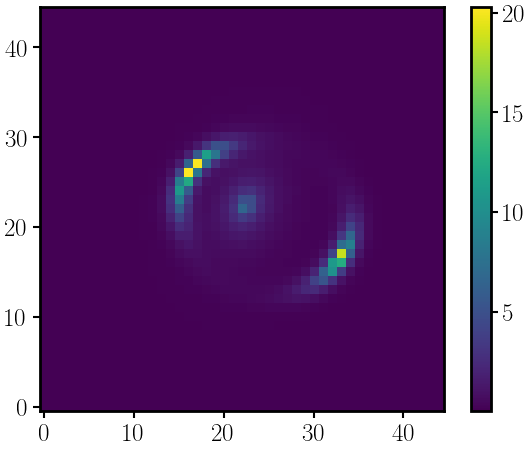

In [2]:
band = 'F106'
exposure_time = 146

lens = SampleStrongLens()
model = lens.get_array(num_pix=45, side=4.95, band=band)

# add CDM subhalos; NB same subhalo population for all
lens.add_subhalos(*pyhalo.unpickle_subhalos(os.path.join(pickle_dir, 'pyhalo', 'cdm_subhalos_tuple')))

plot.plot(model, colorbar=True)

In [3]:
factors = [1, 3, 5, 7, 9]
oversampled = []

save_dir = os.path.join(array_dir, 'sample_skypy_lens')

calculate = False
if calculate:
    for factor in tqdm(factors):
        array = lens.get_array(num_pix=45 * factor, side=4.95, band=band)
        oversampled.append(array)
        np.save(os.path.join(save_dir, f'oversample_{factor}'), array)
else:
    load_files = glob(os.path.join(save_dir, 'oversample_*.npy'))
    oversampled = [np.load(i) for i in load_files]

In [4]:
# get flux
total_flux_cps = lens.get_total_flux_cps(band)
print(total_flux_cps)

292.98421054018536


In [5]:
drawn = []
for factor, array in zip(factors, oversampled):
    interp = InterpolatedImage(Image(array), scale=0.11 / factor, flux=total_flux_cps * exposure_time)
    im = galsim.ImageF(45, 45, scale=0.11)
    im.setOrigin(0, 0)
    drawn.append(interp.drawImage(im).array)

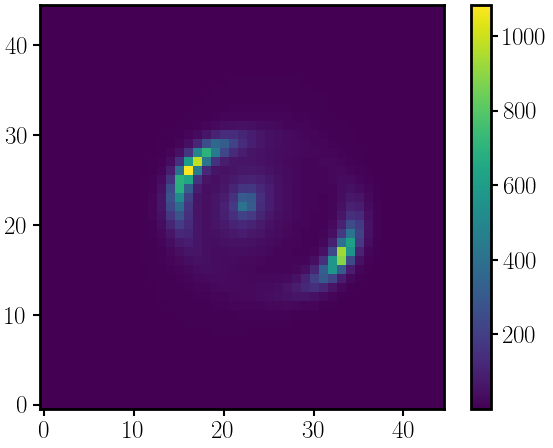

In [6]:
plot.plot(drawn[-1], colorbar=True)

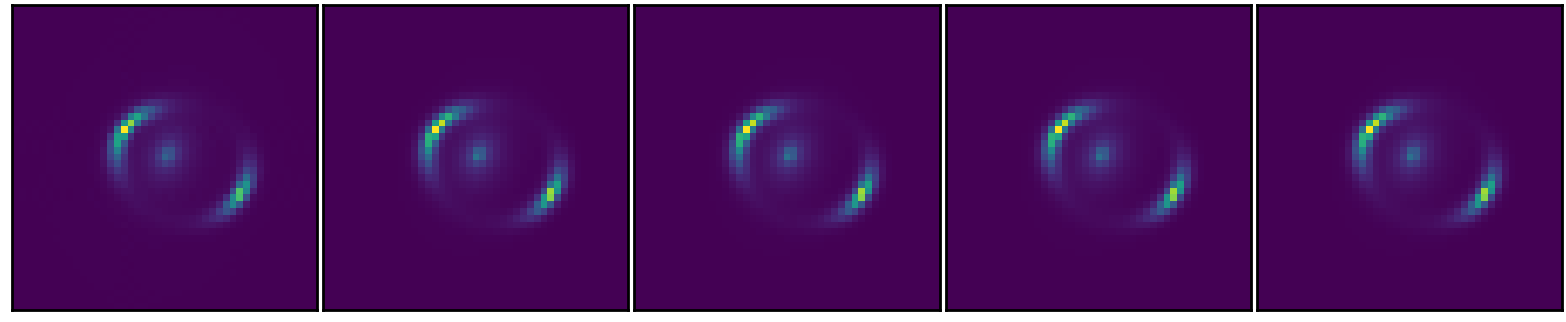

In [7]:
plot.plot_list(drawn)

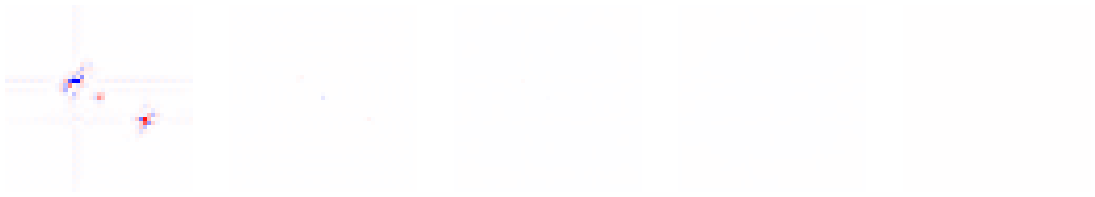

In [8]:
best = drawn[-1]
residuals = [best - i for i in drawn]
v_args = plot_util.set_v(residuals)

f, ax = plt.subplots(1, 5, figsize=(14, 4))
for i, each in enumerate(residuals):
    ax[i].imshow(each, **v_args, cmap='bwr')
    ax[i].set_axis_off()

plt.show()